# Sample size estimation

This notebook will estimate the sample size needed to run an experiment for, given a desired effect, power and significance. As mentioned in the users_and_variance notebook, the data used will start at 2020

In [45]:
from __future__ import annotations
from IPython import get_ipython
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')

from sklearn.linear_model import LinearRegression
from statsmodels.stats.power import tt_ind_solve_power

In [86]:
# Probability of user being baseline
p_baseline = 0.5

def optimal_config(expected_effect, df, metric="sales"):
    df["ratio_time"] = df["ratio"]*df["weeks"]
    df = df[(df["metric"]==metric) & (df["effect"]<=expected_effect)]
    min_df = df[df["ratio_time"]==df["ratio_time"].min()]
    return min_df

In [20]:
base_path = os.path.abspath('')

events_df = pd.read_csv(f"{base_path}/Data/events_complete.csv")
events_df = events_df[events_df["date"]>="2020-01-01"]

np.random.seed(42)
users = events_df["user_id"].unique()
unique_users = pd.DataFrame({"user_id":users, "p_baseline":np.random.uniform(size=len(users))})
events_df = events_df.merge(unique_users, how="left", on="user_id")
events_df = events_df[events_df["p_baseline"]<=p_baseline].drop(["p_baseline"], axis=1)
events_df.head()

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session,time,date,sales,event_type_cart,event_type_purchase,event_type_remove_from_cart,event_type_view,p_baseline
0,2020-01-01 00:00:00 UTC,5809910,1602943681873052386,NaN,grattol,5.24,595414620,4adb70bb-edbd-4981-b60f-a05bfd32683a,2020-01-01 00:00:00+00:00,2020-01-01,0.0,False,False,False,True,0.374540
4,2020-01-01 00:00:25 UTC,5899926,2115334439910245200,NaN,NaN,3.92,484071203,cff70ddf-529e-4b0c-a4fc-f43a749c0acb,2020-01-01 00:00:25+00:00,2020-01-01,0.0,False,False,False,True,0.156019
6,2020-01-01 00:00:37 UTC,5850281,1487580006300255120,NaN,marathon,137.78,593016733,848f607c-1d14-474a-8869-c40e60783c9d,2020-01-01 00:00:37+00:00,2020-01-01,0.0,True,False,False,False,0.155995
7,2020-01-01 00:00:46 UTC,5802440,2151191070908613477,NaN,NaN,2.16,595411904,74ca1cd5-5381-4ffe-b00b-a258b390db77,2020-01-01 00:00:46+00:00,2020-01-01,0.0,False,False,False,True,0.058084
9,2020-01-01 00:01:02 UTC,5850281,1487580006300255120,NaN,marathon,137.78,593016733,848f607c-1d14-474a-8869-c40e60783c9d,2020-01-01 00:01:02+00:00,2020-01-01,0.0,False,False,True,False,0.155995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8421427,2020-02-29 23:59:28 UTC,5817692,1487580010872045658,NaN,NaN,0.79,619841242,18af673b-7fb9-4202-a66d-5c855bc0fd2d,2020-02-29 23:59:28+00:00,2020-02-29,0.0,False,False,False,True,0.413997
8421429,2020-02-29 23:59:32 UTC,5885416,1487580005092295511,NaN,grattol,6.27,622082947,fb29909b-6ef5-4662-b4ee-288e73e5dc10,2020-02-29 23:59:32+00:00,2020-02-29,0.0,False,False,False,True,0.358283
8421430,2020-02-29 23:59:39 UTC,5550686,1487580008145748965,NaN,NaN,1.11,459705611,05d2add3-01f7-47ee-8364-27341673227f,2020-02-29 23:59:39+00:00,2020-02-29,0.0,True,False,False,False,0.219036
8421432,2020-02-29 23:59:54 UTC,5716351,1487580010872045658,NaN,irisk,0.79,619841242,18af673b-7fb9-4202-a66d-5c855bc0fd2d,2020-02-29 23:59:54+00:00,2020-02-29,0.0,False,False,False,True,0.413997


In [24]:
cum_users = pd.DataFrame()

for d in events_df["date"].unique():
    this_df = events_df[events_df["date"] <= d]
    users_df = (this_df
           .groupby("user_id")
           .agg({
                "event_type_purchase":          ["sum", "max"],
                "sales":                        ["sum"],
           })
           ).reset_index()
    users_df.columns = ["user_id", "n_purchases", "has_purchase", "sales"]
    for c in users_df.columns[1:]:
        users_df[f"{c}_sq"] = users_df[c]**2
    aggregated = (
        users_df
        .agg({
            "user_id":"count",
            "n_purchases":"sum",
            "n_purchases_sq":"sum",
            "has_purchase":"sum",
            "sales":"sum",
            "sales_sq":"sum",
        })
        )
    this_line=pd.DataFrame({"date":[d], "cum_users": [aggregated["user_id"]], 
                            "n_purchases_mean":[aggregated["n_purchases"]/aggregated["user_id"]],
                            "n_purchases_sd":[((aggregated["n_purchases_sq"]/aggregated["user_id"])-(aggregated["n_purchases"]/aggregated["user_id"])**2)**(1/2)],
                            "has_purchase_mean":[aggregated["has_purchase"]/aggregated["user_id"]],
                            "has_purchase_sd":[((aggregated["has_purchase"]/aggregated["user_id"])-(aggregated["has_purchase"]/aggregated["user_id"])**2)**(1/2)],
                            "sales_mean":[aggregated["sales"]/aggregated["user_id"]],
                            "sales_sd":[((aggregated["sales_sq"]/aggregated["user_id"])-(aggregated["sales"]/aggregated["user_id"])**2)**(1/2)],
                            })
    cum_users = pd.concat([cum_users, this_line])
cum_users.reset_index(drop=True)
cum_users["days"] = (pd.to_datetime(cum_users["date"]) - pd.to_datetime(cum_users["date"]).min()).dt.days + 1


(-1.9500000000000002, 62.95, 0.0, 396712.4527049181)

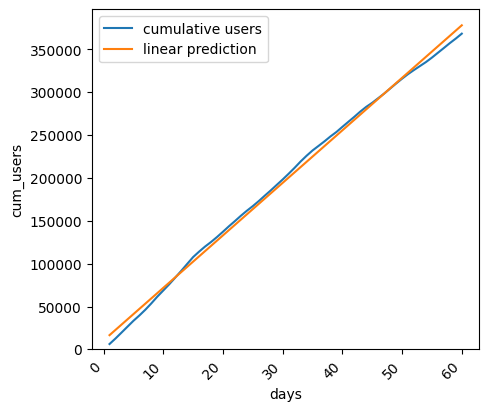

In [25]:
lr = LinearRegression()
lr = lr.fit(X=cum_users["days"].values.reshape(-1, 1), y=cum_users["cum_users"])
lr.predict(X=cum_users["days"].values.reshape(-1, 1))
cum_users["predicted_users"] = lr.predict(X=cum_users["days"].values.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(5, 5))
sns.lineplot(data=cum_users, x="days", y="cum_users", label="cumulative users")
sns.lineplot(data=cum_users, x="days", y="predicted_users", label="linear prediction")
fig.autofmt_xdate(rotation=45)
ax.axis(ymin=0)

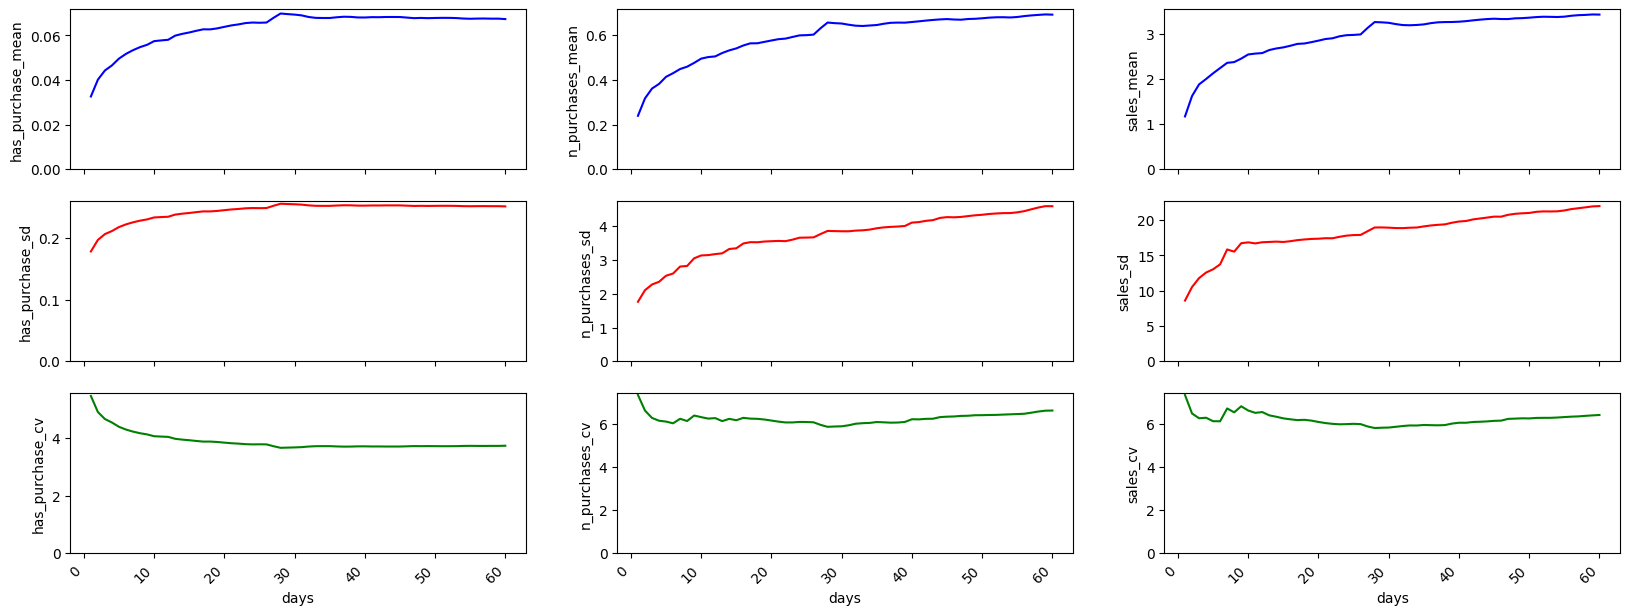

In [28]:
metrics = ["has_purchase", "n_purchases", "sales",]
colors = ["blue", "red", "green", "yellow", "purple"]
fig, ax = plt.subplots(3, len(metrics), figsize=(20, 8))

for i, m in enumerate(metrics):
    cum_users[f"{m}_cv"] = cum_users[f"{m}_sd"]/cum_users[f"{m}_mean"]
    sns.lineplot(data=cum_users, x="days", y=f"{m}_mean", ax=ax[0,i], color=colors[0])
    sns.lineplot(data=cum_users, x="days", y=f"{m}_sd", ax=ax[1,i], color=colors[1])
    sns.lineplot(data=cum_users, x="days", y=f"{m}_cv", ax=ax[2,i], color=colors[2])
    
    ax[0,i].axis(ymin=0)
    ax[1,i].axis(ymin=0)
    ax[2,i].axis(ymin=0)

fig.autofmt_xdate(rotation=45)

The mean and the std seems to keep increasing as the users don't increase linearly, but the CV seems to stabilize. It seems like the same users are making more purchases, as the has_purchase stabilizes after 30 days

<Axes: xlabel='date'>

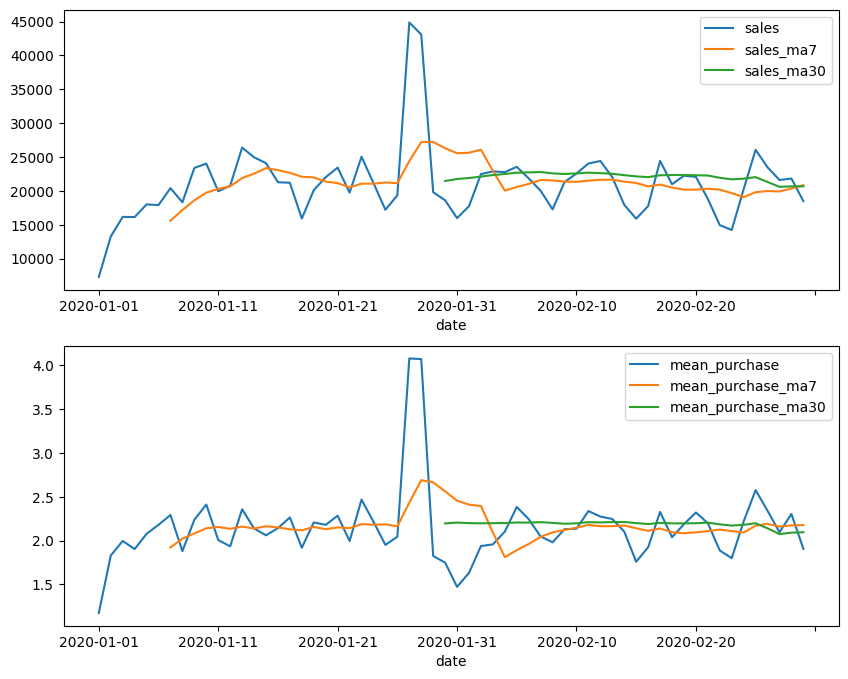

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sales_by_user_day = events_df.groupby("date").agg({"sales":"sum", "user_id": "nunique"}).reset_index()

sales_by_user_day['sales_ma7'] = sales_by_user_day['sales'].rolling(7).mean()
sales_by_user_day['sales_ma30'] = sales_by_user_day['sales'].rolling(30).mean()

sales_by_user_day["mean_purchase"] = sales_by_user_day["sales"] / sales_by_user_day["user_id"]
sales_by_user_day['mean_purchase_ma7'] = sales_by_user_day['mean_purchase'].rolling(7).mean()
sales_by_user_day['mean_purchase_ma30'] = sales_by_user_day['mean_purchase'].rolling(30).mean()

sales_by_user_day.plot(x="date", y=["sales", "sales_ma7", "sales_ma30"], ax=ax[0])
sales_by_user_day.plot(x="date", y=["mean_purchase", "mean_purchase_ma7", "mean_purchase_ma30"], ax=ax[1])


### Sample Size

We estimate sample size based on effect, power, alpha and different ratios for each metric

In [47]:
day_df

,date,cum_users,n_purchases_mean,n_purchases_sd,has_purchase_mean,has_purchase_sd,sales_mean,sales_sd,days,predicted_users,has_purchase_cv,n_purchases_cv,sales_cv
0,2020-01-14,99621.0,0.531344,3.320382,0.06071,0.238798,2.680934,16.961213,14,96238.114782,3.933412,6.249028,6.326606


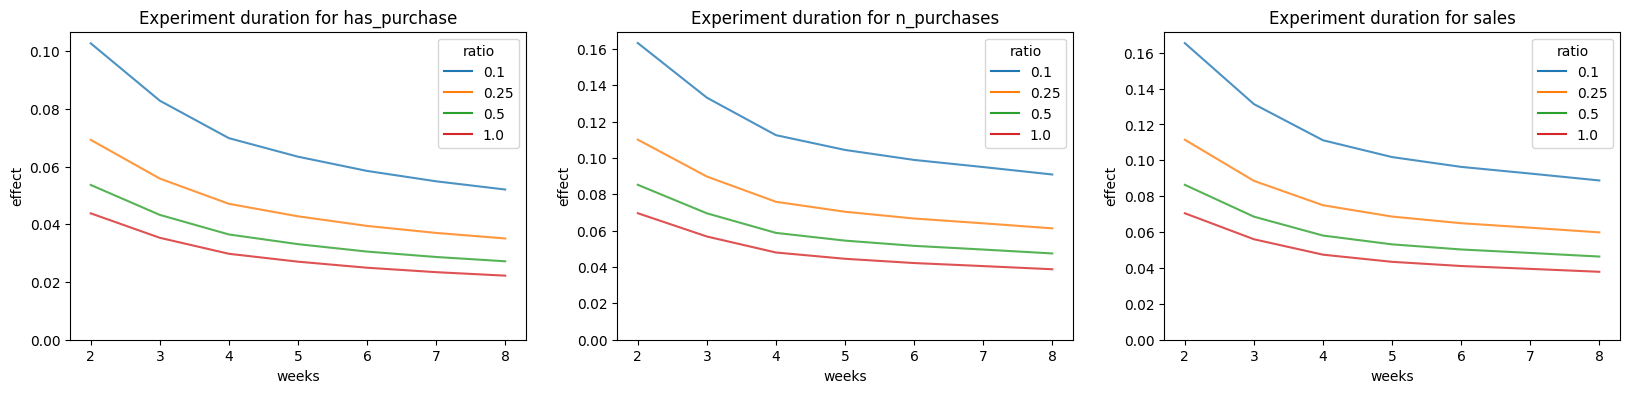

In [80]:
power = 0.8
alpha = 0.05
effect = 0.3 #relative effect on the mean
ratios = [0.1, 0.25, 0.5, 1]
weeks = [2,3,4,5,6,7,8] #considering weekly seasonality, we should run experiments for full weeks

results_df = pd.DataFrame()

for w in weeks:
    day_df = cum_users[cum_users["days"]==w*7]
    for m in metrics:
        for r in ratios:
            effect = tt_ind_solve_power(nobs1=day_df["cum_users"][0], alpha=alpha, power=power, ratio=r, alternative="larger")
            rel_effect = effect*day_df[f"{m}_cv"][0]
            this_result = pd.DataFrame({"metric":[m], "weeks":[w], "ratio":[r], "effect":[rel_effect]})
            results_df = pd.concat([results_df, this_result])

fig, ax = plt.subplots(1, len(metrics), figsize=(20,4))

for i,m in enumerate(metrics):
    sns.lineplot(data=results_df[results_df["metric"]==m], x="weeks", y="effect", hue="ratio", palette="tab10", alpha=0.8, ax=ax[i])
    ax[i].set_title(f"Experiment duration for {m}")
    ax[i].axis(ymin=0)

In [89]:
optimal_config(expected_effect=0.09, df=results_df, metric="sales")

,metric,weeks,ratio,effect,ratio_time
0,sales,3,0.25,0.088535,0.75


We can see that the gains of increasing in time or ratio are marginally decreasing. A 5% effect might be too large for bussiness purposes, we might need to consider some variance reduction techniques